<a href="https://colab.research.google.com/github/michalis0/DataScience_and_MachineLearning/blob/master/Week_4/Week_4_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import to load arff file from url
from scipy.io import arff
import urllib.request
import io

# Sklearn import
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Normalization and standard scaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Label and 1-hot encoding
from sklearn.linear_model import LogisticRegression # Logistic regression model
from sklearn.linear_model import LogisticRegressionCV # Logistic regression with cross-validation
from sklearn.metrics import accuracy_score  # Accuracy
from sklearn.metrics import confusion_matrix # Confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score  # Precision, recall, and f1 score



## Logistic regression

Suppose we have *n* observations of an outcome $\boldsymbol{y}$ and *d* associated features $\boldsymbol{x_1}$, $\boldsymbol{x_2}$, ... , $\boldsymbol{x_d}$ (note that $\boldsymbol{y}$, $\boldsymbol{x_1}$, ..., $\boldsymbol{x_d}$ are vectors):

| | Outcome | Feature 1 | Feature 2 | ... | Feature d |
|:-------|:----------:|:----------:|:----------:|:----------:|:----------:|
| Observation 1 | $y_1$ | $x_{11}$ | $x_{12}$ | ... | $x_{1d}$ |
| Observation 2 | $y_2$ | $x_{21}$ | $x_{22}$ | ... | $x_{2d}$ |
| ... | ... | ... | ... | ... | ... |
| Observation n | $y_n$ | $x_{n1}$ | $x_{n2}$ | ... | $x_{nd}$ |

We will focus on binary classification for now. In other words, our outcome can take two values, 0 and 1, which represent two classes (e.g., cat or dog, spam email or not, risky or safe loan, etc.).

Remember when we did multivariate linear regression, we assumed that our model function $f_{\text{mv}}$, i.e., our prediction, was a linear combination of our features. For each observation $i$, we assumed:
$$f_{\text{mv}}(\boldsymbol{X_{i*}}, \boldsymbol{w}):=w_0 + w_1 x_{i,1} +  w_2 x_{i,2} + ... +  w_d x_{i,d}$$
with $\boldsymbol{w}=(w_0, w_1, ..., w_d)$ the vector of weights, and $\boldsymbol{X}=[\boldsymbol{x_1}$, ... , $\boldsymbol{x_d}]$ the matrix of feature variables.

For each observation, our true outcome was $y_i = f_{\text{mv}}(\boldsymbol{X_{i*}}, \boldsymbol{w}) + \epsilon_i$, and our goal was to minimize the errors.

In this setting, our model function $f_{\text{mv}}$ can take any values. It is thus suited when our outcome is continuous. However, with binary classification, we are dealing with discrete values, and more precisely with 0 and 1. How can we modify our model to obtain proper predictions?

The idea of logistic regression is to transform the predictions obtained with a linear regression such that the predictions are between 0 and 1. To do so, we rely on the [Sigmoid (logistic) function](https://en.wikipedia.org/wiki/Sigmoid_function):

$$S(x) = \frac{1}{1 + e^{-x}}$$

<center>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1280px-Logistic-curve.svg.png' width="300">
</center>

Source: Qef, from [Wikipedia Logistic Curve plot](https://commons.wikimedia.org/wiki/File:Logistic-curve.svg)

With logistic regression, we apply the sigmoid function to the output of the multivariate regression model. Let $f_{\text{logi}}$ be the prediction function of a logistic regression, we have:

$$f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}):= \frac{1}{1 + e^{-(w_0 + w_1 x_{i,1} +  w_2 x_{i,2} + ... +  w_d x_{i,d})}}$$

$f_{\text{logi}}$ represents the probability that a given observation belongs to class 1, i.e., $y_i=1$:
- We predict that the observation belongs to class 1 when $f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}) \geq 0.5$, i.e., when $w_0 + w_1 x_{i,1} +  w_2 x_{i,2} + ... +  w_d x_{i,d} \geq 0$;
- Reciprocally, we predict that the observation belongs to class 0 when $f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w})<0.5$, i.e., $w_0 + w_1 x_{i,1} +  w_2 x_{i,2} + ... +  w_d x_{i,d}<0$.

Now our problem is the same as before: we want to minimize the errors of our model, learning the weights $w_0$, $w_1$, ..., $w_d$ from our data. To do so, we are minimizing our loss function... but which one? We will explore one option below.

  

#### Logistic Loss function

For linear regression, we used the Least Squared Error as loss function:

$$ \min_\boldsymbol{w} \sum_{i=1}^n (y_i - f_{\text{mv}}(\boldsymbol{X_{i*}}, \boldsymbol{w}))^2 $$

Can we use the same for logistic regression? No! Indeed, using Least Squared Error with our new prediction function $f_{\text{mv}}$ would result in a non-convex graph, which is not ideal for our minimization problem since we could be stuck in local minima:

<center>
<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*3o9_XoQP4TaceYPRZVHlxg.png' width="300">
</center>

Source: Issam Laradji, [Non-convex Optimization](https://www.cs.ubc.ca/labs/lci/mlrg/slides/non_convex_optimization.pdf)

So which loss function can we use? Ideally, we want to assign more punishment when predicting 1 while the actual value is 0 and when predicting 0 while the actual value is 1. One such function is the... **Logistic Loss**:

$$L(\boldsymbol{y}, \boldsymbol{X}, \boldsymbol{w})= -\frac{1}{n} \sum_{i=1}^n [y_i \log(f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w})) + (1-y_i) \log(1-f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}))] $$

Let's decompose our function to understand a bit more how it works. For each observation $i$, the cost is:

$$\text{Cost}_i = - y_i \log(f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w})) - (1-y_i) \log(1-f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}))$$

- When $y_i = 1$, $\text{Cost}_i = - \log(f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}))$. Hence, if our predicted probability is 1, we have $\text{Cost}_i=0$, i.e., no cost. However, when our predicted probability is approaching 0, our cost goes to infinity (because the logarithm goes to minus infinity when we get closer to zero).
- When $y_i = 0$, $\text{Cost}_i = - \log(1-f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}))$, and it works the other way around. If our predicted probability is zero, the cost is zero, but when our predicted probability is approaching 1, our cost goes to infinity.

<center>
<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*_NeTem-yeZ8Pr9cVUoi_HA.png' width="400">
</center>

Source: Shuyu Luo, [Loss Function (Part II): Logistic Regression](https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11)

The Logistic Loss not only punishes errors with a very large cost, it is also convex. Hence, we can apply Gradient Descent to obtain the model parameters that minimize the loss!

To learn more:
- [Loss Function (Part II): Logistic Regression](https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11), by Shuyu Luo, Published in Towards Data Science
- [Understanding the log loss function](https://medium.com/analytics-vidhya/understanding-the-loss-function-of-logistic-regression-ac1eec2838ce), by Susmith Reddy, Published in Analytics Vidhya


## Implementation


For the walkthough we will use a **dataset on wine quality**. 

<img src='https://assets.pbimgs.com/pbimgs/rk/images/dp/wcm/202145/0002/schott-zwiesel-classico-wine-glasses-c.jpg' width="300">

The wine data set consists of 11 different parameters of wine such as alcohol content, acidity, and pH, which were measured for several wine samples from the North of Portugal.

Source: P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In *Decision Support Systems*, Elsevier, 47(4):547-553, 2009. Dataset obtained from UCI Machine Learning repository, [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality).

These wines were derived from different cultivars; therefore there have different quality, as a score between 0 and 10. We grouped the wines into two quality classes: 0 and 1, representing respectively  "poor quality" (score 0-5), and "good quality" (score 6-10).

Our goal here is to find a model that can predict the class of wine given the 11 measured parameters, and find out the major differences among the two classes.



### Load and discover dataset

In [6]:
#Load the dataset
wines = pd.read_csv("wine-quality-red.csv")

# Display a sample of the data
display(wines.head())

# Print columns
print(wines.columns.values)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,0


['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol' 'quality']


Note that we only have numerical variables, and thus won't need to encode any categorical variables.

However, we will need to rescale our features since, they are on different scales: for instance, chlorides values are lower than 1 while sulfur dioxide can attain a value of 289.

In [7]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.875547,46.468418,0.996747,3.311113,0.658149,10.422983,0.534709
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460434,32.895920,0.001887,0.154386,0.169507,1.065668,0.498950
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,1.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


We now define our features - all wine parameters - and our target variable - the wine quality:

In [8]:
# Define features and target variable
X = wines.drop(columns='quality')
y = wines['quality']

We know check how many observations we have for each class:

In [9]:
# Count the number of observations (rows) corresponding to each value
y.value_counts()

quality
1    855
0    744
Name: count, dtype: int64

We have 855 "good" quality wines and 744 "poor" quality wines. The number of observations for each class influence the quality of our predictions. Here, our dataset is reasonably balanced.

### Splitting the dataset

As always, the first step is to split our data into random training and test subsets. Recall that the training set is used to learn the parameters of our model while the test set is used to evaluate our predictions.

We use the `train_test_split` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) of sklearn and reserve 25% of the original data as test set.

In [10]:
#Split data set into a train and a test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)

print(f"The training set has {X_train.shape[0]} observations, and the test set has {X_test.shape[0]} observations.")

The training set has 1199 observations, and the test set has 400 observations.


### Rescaling

When we have a dataset with features with very distinct ranges, many ML models (including logistic regression) might produce biased results. Thus we want the features to be in the same or similar range, which also helps the interpretation of the model parameters (weights). We therefore **normalize** the data. In our example solution below we will normalize both our **train AND test data** using the `MinMaxScaler()`([Documentation](https://scikit-learn.org/0.15/modules/generated/sklearn.preprocessing.MinMaxScaler.html)). 

In [12]:
# Define the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(X_train) # here the scaler learns the min and max of each attribute from the training set

# Transform the train and the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


### Building and training our classifier

To predict the class of our target variable we use a logistic regression. The sklearn module is called `LogisticRegression()` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)). 

Note that L2-regularization is applied by default. By specifying the argument *penalty*, you can specify the regularization techniques, namely 'l1', 'l2', 'elasticnet', or None.

You can also specify the *solver*. By default, 'lbfgs' is used, which stands for [Limited-memory Broyden–Fletcher–Goldfarb–Shanno](https://en.wikipedia.org/wiki/Limited-memory_BFGS).
Note that the choice of the algorithm depends on the penalty chosen. You can refer to the documentation for insights on the choice of solver/penalty depending on your problem and data.

**A short note on solver:**
L-BFGS approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm ([BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)), which is based on [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization), an alternative to Gradient Descent. While the Gradient Descent rely on the gradient (first-order derivatives) to update our parameters, Newton's method also makes use of the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix), i.e., the second-order derivatives. Newton's method generally converges faster than Gradient Descent. However, Newton's method is computationally-expensive and the Hessian might not even exist. Hence, numerical methods called [Quasi-Newton](https://en.wikipedia.org/wiki/Quasi-Newton_method), such as BFGS, have been developed to solve optimization problems.  

In [13]:
# 1. Set up our model
model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

# 2. Fit our model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

After fitting the model, we can easily retrieve the values of the different weights coefficients: the intercept with `.intercept_`, and the weights of each feature with `.coef_.flatten()`:

In [14]:
# Dataframe with the intercept and coefficients (weights) of the logistic model
model_coeff = pd.DataFrame(np.concatenate((model.intercept_, model.coef_.flatten())),
                     index=["Intercept"] + list(X.columns.values),
                     columns=['Coefficients logistic model'])
model_coeff

,Coefficients logistic model
Intercept,-0.096618
fixed acidity,1.060667
volatile acidity,-3.335574
citric acid,-0.269326
residual sugar,0.596732
chlorides,-1.266971
free sulfur dioxide,0.391015
total sulfur dioxide,-2.752863
density,-0.782913
pH,-0.245513


It seems like the level of alcohol and volatile acidity were the most important features to predict the wine quality, at least in our model.

### Using the classifier to make prediction

Once our model has been trained, we can use `predict()` to predict new values. We predict the values from the test set to then evaluate the model, estimating the accuracy of our classifier.

In [15]:
y_pred = model.predict(X_test)

We can even access the probabilities that one observation belongs to one class or the other with `predict_proba()`. The largest probability determines the predicted class.

In [16]:
# Dataframe with probabilities that our first 5 observations belong to each class
model_proba = pd.DataFrame(model.predict_proba(X_test)[0:4],
                     columns=['Probability poor-quality wine', 'Probability good wine'])
model_proba

,Probability poor-quality wine,Probability good wine
0,0.352811,0.647189
1,0.727663,0.272337
2,0.089182,0.910818
3,0.586545,0.413455


###  Evaluating our classifier

We will now evaluate the performance of our classifier using several metrics.

#### Accuracy

For a sklearn classifier, this can be computed using the `score` method.

In [17]:
# Accuracy on the test set
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(model.score(X_test, y_test)))

# Accuracy on the training set
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(model.score(X_train, y_train)))

Accuracy of Logistic regression classifier on test set: 0.75
Accuracy of Logistic regression classifier on training set: 0.74


Alternatively, we could use the `accuracy_score` module:



In [18]:
accuracy_test = accuracy_score(y_test, y_pred)

print(f'Accurary of Logistic regression classifier on test set: {accuracy_test :.2f}')

Accurary of Logistic regression classifier on test set: 0.75


When the testing accuracy is much lower than the training accuracy, we have an overfitting issue. Reciprocally, when the testing accuracy is similar to or higher than the training accuracy, the model might be underfitting, and we could consider either using a more powerful model or adding additional
features.

Our testing accuracy is 75%. Is that good? It depends! The quality of our prediction depends on the distribution of the classes in our original data:

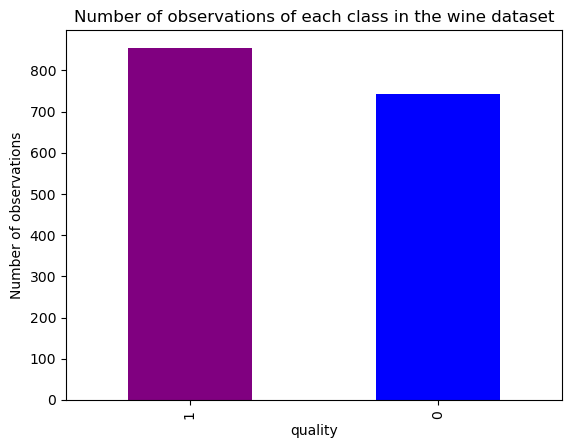

In [19]:
y.value_counts().plot.bar(color=['purple', 'blue'], grid=False)
plt.ylabel('Number of observations')
plt.title('Number of observations of each class in the wine dataset');

Imagine we have a naive classifier that always predict the majority class. We call the default rate (or base rate) the accuracy of this classifier, which is equal to the size of the most common class over the size of the full dataset:

$$\text{Default rate} = \frac{\# \text{ most frequent class}}{\# \text{ total observations}}$$

If the default rate is too high, then the classification can be biased, meaning that the data set has too many observations of one class compared to the other classes, and has hence more impact on the classification results.

The accuracy of our classifier should be better than the default rate. Let's calculate this default rate!

In [20]:
# Compute the default rate
quality_0 = wines.loc[wines["quality"] == 0].shape[0]
print('# occurrence of class 0: ', quality_0)
quality_1 = wines.loc[wines["quality"] == 1].shape[0]
print('# occurence of class 1: ', quality_1)
defaultrate = max(quality_0, quality_1)/(wines["quality"].shape[0])
print(f'Default rate = {defaultrate:0.4f}')

# occurrence of class 0:  744
# occurence of class 1:  855
Default rate = 0.5347


The default rate for our task is about 53.5% while our classifier accuracy is 75%. Not too bad!

#### Confusion matrix

The confusion matrix allows us to get more details on the performance of our model. It will allow us to see what our classification model is getting right and what types of errors it is making. So let's compute it. It requires as input the true values and the predicted values:

In [21]:
confusion_matrix(y_test, y_pred)

array([[137,  48],
       [ 52, 163]])

To obtain a more visual representation, we will use `heatmap` from the `seaborn` library:

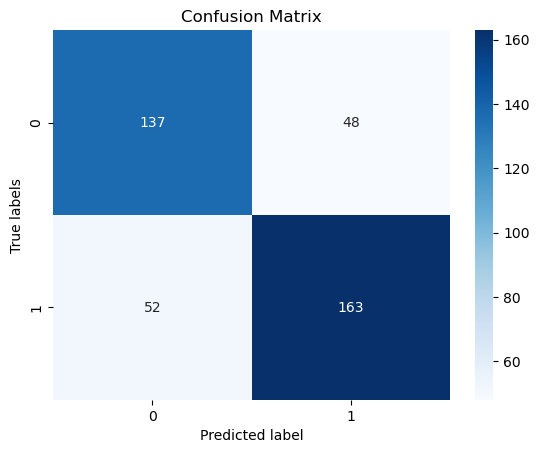

In [22]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix');

#### Precision, Recall, F Score

We will compute the precision using `precision_score` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)), the recall using `recall_score` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)), and the F1 score using `f1_score` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)).

For a binary classifier, all metrics will report by default the scores associated with the positive class (i.e., with observations equal to 1). If we are interested in the results for another class, we need to specify this in the parameters. For instance, the parameter `average = None` will return the scores of each class:

In [23]:
print('The precision for class 1 (good wines) is: {:0.3f}'.format(precision_score(y_test, y_pred)))
print('The recall for class 1 is: {:0.3f}'.format(recall_score(y_test, y_pred)))
print('The F1 score for class 1 is: {:0.3f}'.format(f1_score(y_test, y_pred)))

The precision for class 1 (good wines) is: 0.773
The recall for class 1 is: 0.758
The F1 score for class 1 is: 0.765


In [24]:
# Precision of each class
model_precision = precision_score(y_test, y_pred, average = None)
# Recall of each class
model_recall = recall_score(y_test, y_pred, average = None)
# F1 score of each class
model_f1 = f1_score(y_test, y_pred, average = None)

# Visualize all results in a dataframe:
model_eval = pd.DataFrame([model_precision, model_recall, model_f1],
                    index = ['Precision', 'Recall', 'F1 score'],
                    columns=['Class 0', 'Class 1'])
model_eval

,Class 0,Class 1
Precision,0.724868,0.772512
Recall,0.740541,0.758140
F1 score,0.732620,0.765258


You can find all the sklearn model evaluation metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

## Your turn !

Now it's your turn to use logistic regression! In this application, you will try to predict whether a forest fire spread and burned forest areas in the Montesinho natural park in Portugal.

We are using the [Forest Fires dataset](https://www.kaggle.com/datasets/sumitm004/forest-fire-area), created by Paulo Cortez and Aníbal Morais, and available on Kaggle.

Source: P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimaraes, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9.

The original dataset contains 13 columns:
- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- month - month of the year: "jan" to "dec"
- day - day of the week: "mon" to "sun"
- FFMC - Fine Fuel Moisture Code (FFMC) index from the [Fire Weather Index (FWI)](https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system) system: 18.7 to 96.20
- DMC - Duff Moisture Code (DMC) index from the FWI system: 1.1 to 291.3
- DC - Drought Code (DC) index from the FWI system: 7.9 to 860.6
- ISI - Initial Spread Index (ISI) index from the FWI system: 0.0 to 56.10
- temp - temperature in Celsius degrees: 2.2 to 33.30
- RH - relative humidity in %: 15.0 to 100
- wind - wind speed in km/h: 0.40 to 9.40
- rain - outside rain in mm/m2 : 0.0 to 6.4
- area - the burned area of the forest (in ha): 0.00 to 1090.84

In addition, we created a new column, "class", detailing whether the fire burned an area of forest:
- class is equal to 0 if area = 0.00 ha
- class is equal to 1 if area > 0.00 ha

Our goal will be to predict the ***class*** using logistic regression, given the weather and FWI features.

In [25]:
# Load data
forest_fire = pd.read_csv("forestfires.csv")

### Discover your dataset

- Explore your dataset, displaying a few observations, the types of your data, some summary statistics, and the correlation matrix. Feel free to push forward your EDA using a few graphs e.g., boxplot and pairplot.

In [ ]:
# YOUR CODE HERE

# Display a sample of the data, the data types, summary statistics, correlations, ranges of input features...


### Multi-features logistic regression

We'll start with only four features, the temperature, the rain, the FFMC and wind.

- Define your features and target variable ('class'):

In [30]:
# YOUR CODE HERE


- Split you data intro training and test set (use 20% from the data as test set):

In [31]:
# YOUR CODE HERE


- Rescale your data, using the scaler of your choice:

In [32]:
# YOUR CODE HERE


- Build and train a simple logistic regression classifier:

In [ ]:
# YOUR CODE HERE


- Compare the training and testing accuracy of your model

In [ ]:
# YOUR CODE HERE


- Compute the default rate and compare it to the accuracy of your model. What do you think?

In [ ]:
# YOUR CODE HERE


- Analyse the results further by looking at the confusion matrix, precision, recall and F1 Score. What do you think?

In [ ]:
# YOUR CODE HERE
